# NICE

This is an algorithm for compressing images, modeled as arrays of 8x8 RGB blocks, into much smaller latents.

### Dataset

Download the dataset from Kaggle. The dataset was built from COCO, where each image was sampled for 8x8 RGB blocks.
The dataset consists of a training and validation split. Each split is a flat Nx3x8x8 tensor with an 8-bit integer data type.

In [3]:
import kagglehub
from pathlib import Path
datasets_path = Path(kagglehub.dataset_download('tay10r/image-block-compression'))

import torch
class BinDataset(torch.utils.data.Dataset):
    """
    This dataset is for sampling from .bin files containing an array of 3x8x8 blocks.
    """
    def __init__(self, filename: Path):
        with open(filename, 'rb') as f:
            self.__data = f.read()
        self.__num_samples = len(self.__data) // (3 * 8 * 8)

    def __len__(self) -> int:
        return self.__num_samples

    def __getitem__(self, index) -> torch.Tensor:
        s = 3 * 8 * 8
        offset = index * s
        block: bytes = self.__data[offset:offset+s]
        # This will produce a warning about a non-writable tensor.
        # It's annoying, but just try to ignore it.
        return torch.frombuffer(block, dtype=torch.uint8, count=s).reshape(3, 8, 8)

import numpy as np
class RemoteImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_url: str):
        import requests
        response = requests.get(image_url)
        response.raise_for_status()
        from PIL import Image
        from io import BytesIO
        self.__image = np.transpose(np.asarray(Image.open(fp=BytesIO(response.content))), axes=(2, 0, 1))

    def __len__(self) -> int:
        C, H, W = self.__image.shape
        y = H // 8
        x = W // 8
        return x * y

    def __getitem__(self, index: int) -> torch.Tensor:
        w = self.__image.shape[2]
        x = index % w
        y = index // w
        return torch.from_numpy(self.__image[:, y * 8, x * 8])

train_data = BinDataset(datasets_path / 'train.bin')
val_data = BinDataset(datasets_path / 'val.bin')
demo_data = RemoteImageDataset(image_url='https://raw.githubusercontent.com/mikolalysenko/baboon-image/master/baboon.png')

### Network

Now we'll define the network, which consists of an encoder and decoder.
We define these as two separate networks, since in practice they are used separately.

In [ ]:
import torch

import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(torch.nn.Module):
    def __init__(self, hidden: int, outputs: int):
        super().__init__()
        self.__layers = torch.nn.Sequential(
            torch.nn.Linear(8 * 8 * 3, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, outputs)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.flatten(x, start_dim=1)
        x = self.__layers(x)
        return x

class Decoder(torch.nn.Module):
    def __init__(self, input_features: int, hidden: int):
        super().__init__()
        self.__layers = torch.nn.Sequential(
            torch.nn.Linear(input_features, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, 8 * 8 * 3)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.__layers(x)
        x = x.reshape(x.shape[0], 3, 8, 8)
        return x

class Net(nn.Module):
    def __init__(self, num_stages: int, hidden: int = 32):
        super().__init__()
        self.__num_stages = num_stages
        self.__encoders = nn.ModuleList([Encoder(hidden, num_stages) for _ in range(num_stages)])
        self.__decoders = nn.ModuleList([Decoder(num_stages, hidden) for _ in range(num_stages)])
        self.__z_proj = nn.ModuleList([torch.nn.Linear(num_stages, 1) for _ in range(num_stages)])

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        zs: list[torch.Tensor] = []
        xk = x
        yi: torch.Tensor = torch.zeros(size=x.shape)
        for i in range(self.__num_stages):
            wi = self.__encoders[i](xk)
            zs.append(self.__z_proj[i](wi))

            w_cat = torch.cat([torch.concat(zs, dim=1), wi[:, i+1:self.__num_stages]], dim=1)
            yi = self.__decoders[i](w_cat)

            if i < self.__num_stages - 1:
                xk = xk + yi
        z_final = torch.cat(zs, dim=1)
        return yi, z_final

device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'compute device: {device_name}')
dev = torch.device(device_name)
net = Net(num_stages=8).to(dev)

compute device: cuda


### Training the Network

We're going to train on the COCO dataset. Since it's very large and takes a long time,
we're going to break it up into 1000 iterations. So every 1000 training samples, we will
check the validation loss and evaluate the demo image.

In [189]:
def forward(net: Net, x: torch.Tensor) -> torch.Tensor:
    #z = enc(x)
    #y = dec(z)
    y, z = net(x)
    loss = torch.nn.functional.mse_loss(y, x)
    return loss

def val(net: Net, data: torch.utils.data.DataLoader, dev: torch.device) -> float:
    net.eval()
    val_loss_sum = 0.0
    with torch.no_grad():
        for batch in data:
            x: torch.Tensor = batch
            x = x.to(dev).float() * (1.0 / 255.0)
            val_loss_sum += forward(net, x).item()
    return val_loss_sum / len(data)

def train(net: Net, train_data: torch.utils.data.Dataset, val_data: torch.utils.data.Dataset, dev: torch.device):
    batch_size = 1024
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=False)
    #optimizer = torch.optim.AdamW(list(enc.parameters()) + list(dec.parameters()))
    optimizer = torch.optim.AdamW(net.parameters())
    counter = 0
    net.train()
    epochs = 4
    for epoch in range(epochs):
        for batch in train_loader:
            x: torch.Tensor = batch
            x = x.to(dev).float() * (1.0 / 255.0)
            loss = forward(net, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            counter += 1
            if counter % 1000 == 0:
                val_loss = val(net, val_loader, dev)
                print(f'[{counter // 1000}]: {val_loss:.06f}')
                net.train()

train(net, train_data, val_data, dev)

[1]: 0.004500
[2]: 0.004335
[3]: 0.004240
[4]: 0.004167
[5]: 0.004136
[6]: 0.004163
[7]: 0.004047
[8]: 0.004013
[9]: 0.003974
[10]: 0.003960
[11]: 0.003964
[12]: 0.003944
[13]: 0.003919
[14]: 0.003915
[15]: 0.003916
[16]: 0.003897
[17]: 0.003902
[18]: 0.003884
[19]: 0.003885
[20]: 0.003903
[21]: 0.003863
[22]: 0.004153
[23]: 0.003871
[24]: 0.003832
[25]: 0.003849
[26]: 0.003953
[27]: 0.003815
[28]: 0.003821
[29]: 0.003833
[30]: 0.003817
[31]: 0.003801
[32]: 0.003858
[33]: 0.003825
[34]: 0.003842
[35]: 0.003869
[36]: 0.003837


KeyboardInterrupt: 

## Analyzing the Latent Vectors

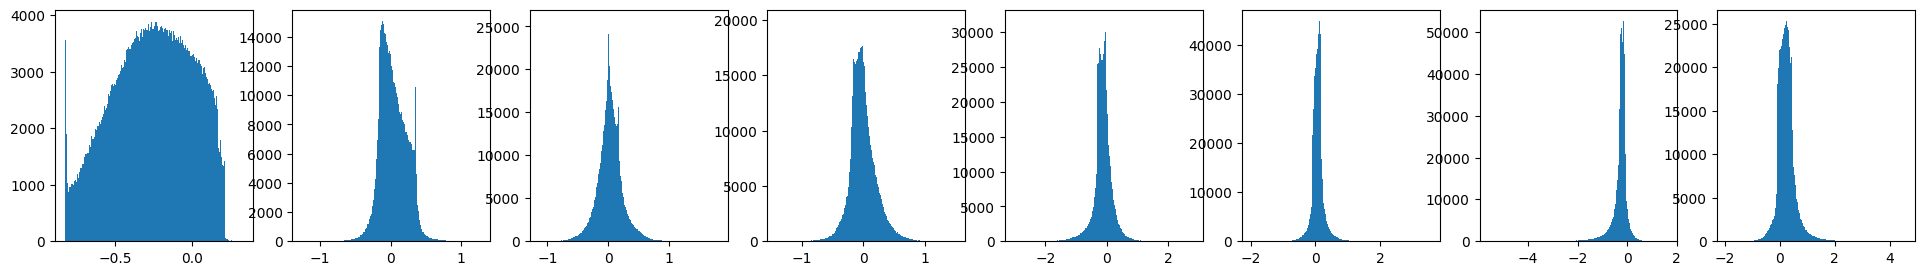

In [191]:
from matplotlib import pyplot as plt

# generate an array of latents
z_list: list[torch.Tensor] = []
with torch.no_grad():
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=128)
    for batch in val_loader:
        x: torch.Tensor = batch
        _, z = net(x.to(dev).float() * (1.0 / 255.0))
        z_list.append(z.cpu())
    latents = torch.cat(z_list, dim=0).numpy()

%matplotlib inline

fig, ax = plt.subplots(1, 8, figsize=(24, 3))

for i in range(8):
    ax[i].hist(latents[:, i], bins=256)

plt.show()